Engy-4350: Nuclear Reactor Engineering Spring 2019 UMass Lowell; Prof. V. F. de Almeida **19Mar2019**, Austin T. Rotker **Aug2019**

# 05. Two-Temperature Boiling Water Reactor Example B
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

---
## Table of Contents
* [Objectives](#obj)
* [Introduction](#intro)
* [Problem Statement](#ps)
* [Reactor Starup And Steady State](#res1)
* [Condenser Malfunction Results](#res2)
* [Reactor Shutdown Results](#res3)

---

## Objectives<a id="obj"></a>
+ Use one-group energy, two-temperature, point-reactor dynamics modeling (six-group delayed neutron emitters) to obtain insight on neutron density behavior with time-dependent reactivity of a Boiling Water Reactor during startup, steady state operation, shutdown and condenser malfunctions.
+ Explore and understand intrinsic temperature reactivity coefficient feedback from nuclear sources.

## Introduction<a id="intro"></a>

In-class course notes OneNote [ChEn-4350-feedback](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eo9JUns42F1Pqmq4tFS9sJsBv2jF8UDQvRb5l5Z2D5ssag?e=FDeSpV).

Refer to Notebook 03.


## Problem Statement<a id="ps"></a>

Consider a boiling water reactor reactor, with UO$_2$ fuel and a light water coolant and moderator.
Given the neutron generation time $\ell$, delayed neutron fraction, $\beta$, decay constants of a six-group delayed neutron emitters, $\lambda_i$, and corresponding yield of delayed neutron fractions for each emitter, $\beta_i$, calculate the pointwise neutron density variation with time for **varying** neutron reactivity, $\rho(t)$.

![](images/point-reactor-hx.png)

The below functions are used to import the functions written in 05-bwr-two-temperature-pt-reactor-A for the sake of simplicity. They are taken from https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html.

In [1]:
!pip install iapws
import numpy as np



You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import iapws.iapws97 as steam_table
params = dict()

#Data pertaining to one-group energy neutron balance
params['gen_time']     = 1.0e-4  # s
params['beta']         = 6.5e-3  # 
params['k_infty']      = 1.34477
params['buckling'] = 1.538e-4
params['q_0'] = 0

params['n_dens_ss_operation'] = 1 #1.963e13/2200 * 1e4 #  #neutrons/m^2

params['alpha_n'] = -1.5e-3 # control rod reactivity worth

#Delayed neutron emission
params['species_decay']     = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01] # 1/sec
params['species_rel_yield'] = [0.033, 0.219, 0.196, 0.395, 0.115, 0.042] 

#Data pertaining to two-temperature heat balances
params['fis_energy']           = 180 * 1.602e-13 # J/fission 
params['enrich']               = 4.3/100.
params['fuel_mat_mass_dens']   = 10.5 # g/cc
#params['moderator_fuel_ratio'] = 387 # atomic number concentration ratio
params['sigma_f_o']            = 586.2 * 100 * 1e-30 # m2
params['temp_o']               = 20 + 273.15 # K
params['temp_c_ss_operation']  =287.2 +273.15# K desired ss operation temp of coolant
params['thermal_neutron_velo'] = 2200 # m/s

params['fis_nuclide_num_dens_fake'] = 9.84e26 # (fissile nuclei)/m3

params['q_c'] = 303 # volumetric flow rate

params['fuel_dens']   = 10500 # kg/m3
params['cp_fuel']     = 300 # J/(kg K)
params['fuel_volume'] = 15.0157429 # m3

params['steam flowrate'] = 1820 # kg/s
params['coolant_dens']   = 600 #  kg/m3
params['cp_coolant']     =  4000# J/(mol K) - > J/(kg K)
params['coolant_volume'] = 3000 # m3

params['ht_coeff'] = 700000000 # W/K

params['m2'] = 22

params['turbine efficiency'] = 0.8 
params['condenser efficiency'] = 0.8
params['pump efficiency'] = 0.8

params['fis_prod_beta_energy_rate']  = 1.26 * 1.602e-13 # J/(fission sec) 1.26 t^-1.2 (t in seconds)
params['fis_prod_alpha_energy_rate'] = 1.40 * 1.602e-13 # J/(fission sec) 1.40 t^-1.2 (t in seconds)
# % subcooling based on the % subcooling that exists at steady state
params['% subcooling'] =  (1 -(steam_table._Region4(7, 0)["h"]  - steam_table._Region1(493.15, 7)["h"])/(steam_table._Region4(7,0)["h"]))

params['shutdown temp reached'] = False

<a id="res2"></a>
# Steady State Reactor Startup Followed By Condenser Malfunction
The reactor is started up as normal, and some time is allowed to pass with the reactor functioning at steady state. After this time has passed, the condenser experiences a malfunction wherein the degree of subcooling of the liquid leaving the condenser is decreased for a period of time, leading to an increase in reactor operating temperatures.

In [18]:
'''Setup up initial conditions'''

import numpy as np
import reactor

params['malfunction start'] = 1300
params['malfunction end'] = 2000
params['breakage start'] = 1300
params['breakage end'] = 0
params['shutdown time'] = 1300
params['malfunction subcooling'] = 0.9

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $

beta = params['beta'] # retrieve the delayed neutron fraction
params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 2 # s

# setup remaining initial conditions
reactor.setup_initial_conditions(params)

In [19]:
'''Evolve the point-reactor'''

time_final    = 3000# 450 # s
n_time_stamps = 500 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = reactor.run_point_reactor( reactor.f_vec, params )
#print(u_vec_history)
print("done")


done


Text(0.5, 1.0, "Heat Removed and Q''' vs Time During Condenser Malfunction")

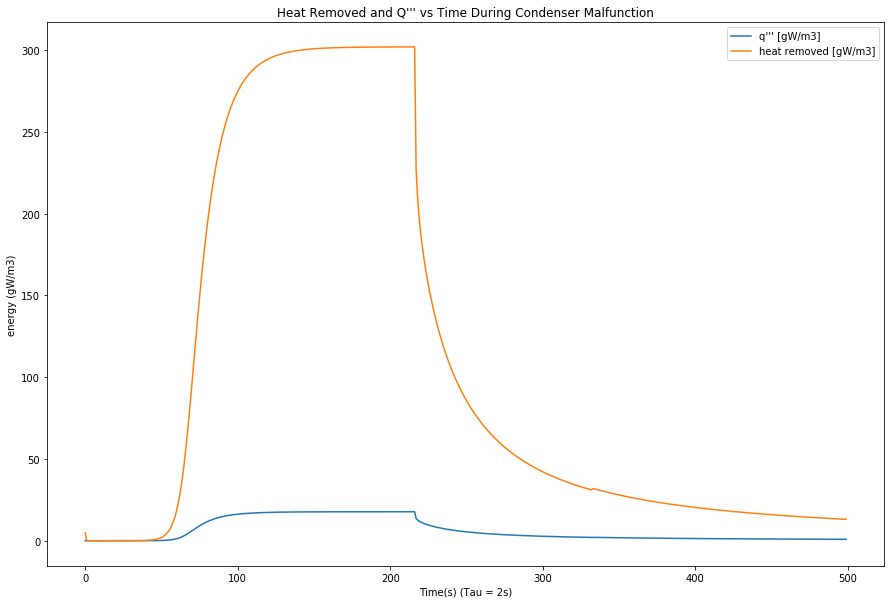

In [20]:
heat_data = reactor.quantities1(u_vec_history, params, params['time_stamps'])
plot = heat_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)
plot.set_xlabel("Time(s) (Tau = 2s)")
plot.set_ylabel("energy (gW/m3)")
plot.set_title("Heat Removed and Q''' vs Time During Condenser Malfunction")


The condenser malfunction modeled here results in a decrease in the subcooling of the liquid leaving the condenser, resulting in higher inlet temperatures $T_\text{in}$. This higher inlet temperature reduces the heat removed from the system following newton's law of cooling, whereby the heat removed from the system is proportional to:

\begin{equation*}
T_\text{fuel} - T_\text{in}
\end{equation*}

With an increase in the second term causing a corresponding decrease in the heat removed from the system.

Text(0.5, 1.0, 'Turbine, Condenser and Net Power vs Time For Condenser Malfunction')

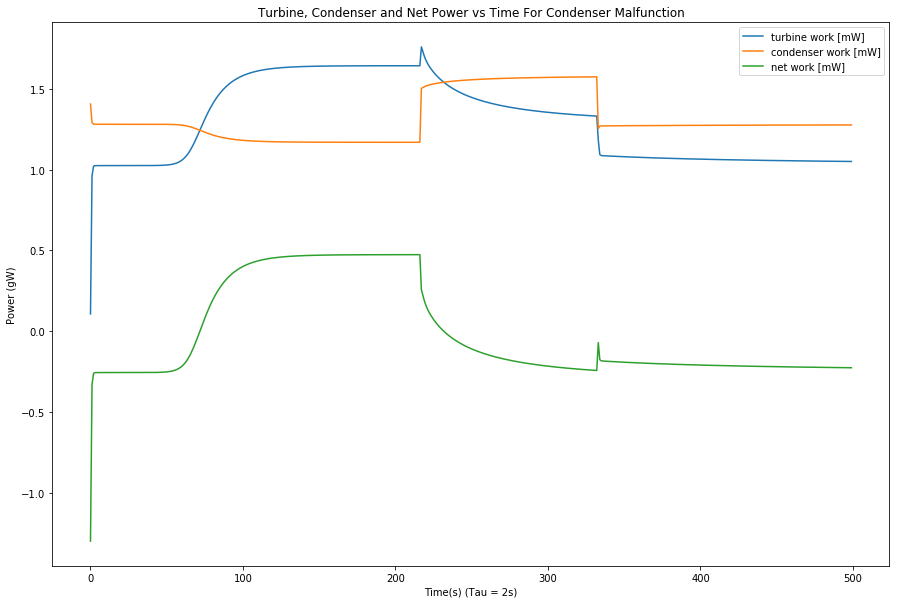

In [21]:
work_data1 = reactor.quantities2(u_vec_history, params, params['time_stamps'])
plot = work_data1.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)
plot.set_xlabel("Time(s) (Tau = 2s)")
plot.set_ylabel("Power (gW)")
plot.set_title("Turbine, Condenser and Net Power vs Time For Condenser Malfunction")

Loss of subcooling leads to an immediate spike in the temperature of the coolant entering the reactor, and therefore another spike in the temperature of the coolant leaving the reactor. This higher temperature also leads to a spike in turbine work around the same time. However, the rise in the temperature of the coolant also leads to a reduction in the heat removed by the coolant as the total heat transferred is reduced. This leads to turbine work gradually falling and condenser work gradually increasing as reactor temperature continues to gradually increase for the duration of the condenser malfunction.

At the end of the malfunction, condenser subcooling returns to normal, leading to an immediate decrease in the temperatures in the reactor. This causes turbine work to decrease with the decreasing coolant temperature, and condenser work to increase, leading to a new steady state condition.

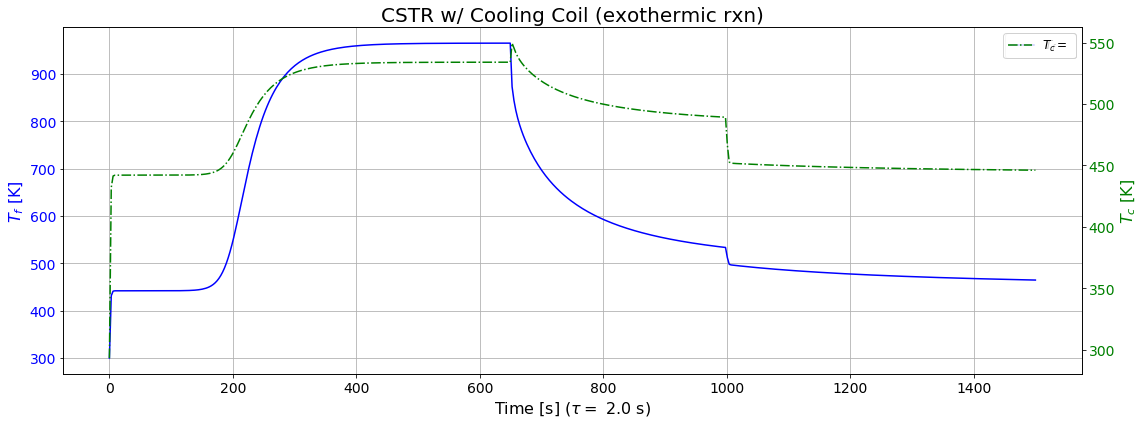

In [22]:
reactor.tmp(u_vec_history, params)

During the condenser malfunction, the operating temperatures of the reactor increase to about 500 K for the coolant and 550 K for the fuel, before decreasing to normal operating levels after the end of the malfunction.

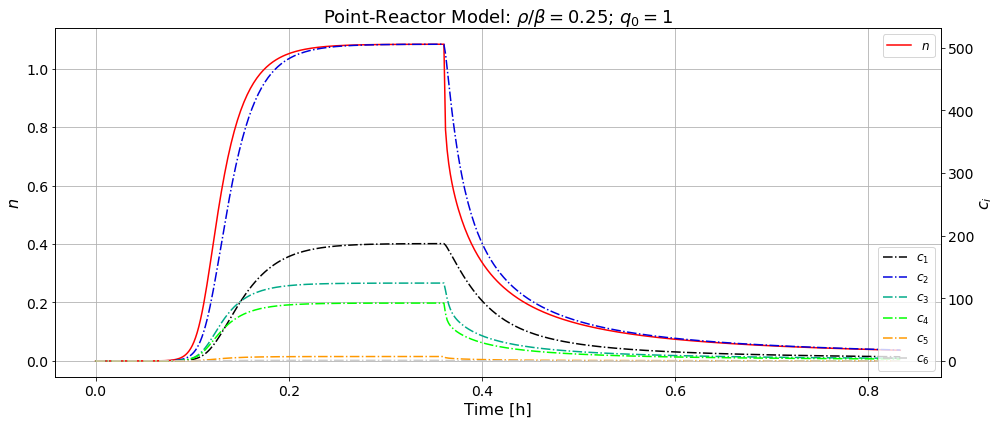

In [23]:
reactor.plot_results(u_vec_history, params, normalize=False)

Due to an extremely small temperature reactivity coefficient, there is no observable effect on the neutron density in the reactor during or after the condenser malfunction.

<a id="res3"></a>
# Shutdown
The reactor starts up as normal, operates for a certain period of time at steady state, and then shuts down to zero power.

In [9]:
'''Setup up initial conditions'''

import numpy as np
import reactor

params['malfunction start'] = 13000
params['malfunction end'] = 0
params['breakage start'] = 13000
params['breakage end'] = 0
params['shutdown time'] = 2000

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $

beta = params['beta'] # retrieve the delayed neutron fraction
params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 2 # s

# setup remaining initial conditions
reactor.setup_initial_conditions(params)

In [10]:
'''Evolve the point-reactor'''

time_final    = 12000# 450 # s
n_time_stamps = 1000 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = reactor.run_point_reactor( reactor.f_vec, params )
#print(u_vec_history)
print("done")

done


Text(0.5, 1.0, "Heat Removed and Q''' vs Time During Reactor Shutdown")

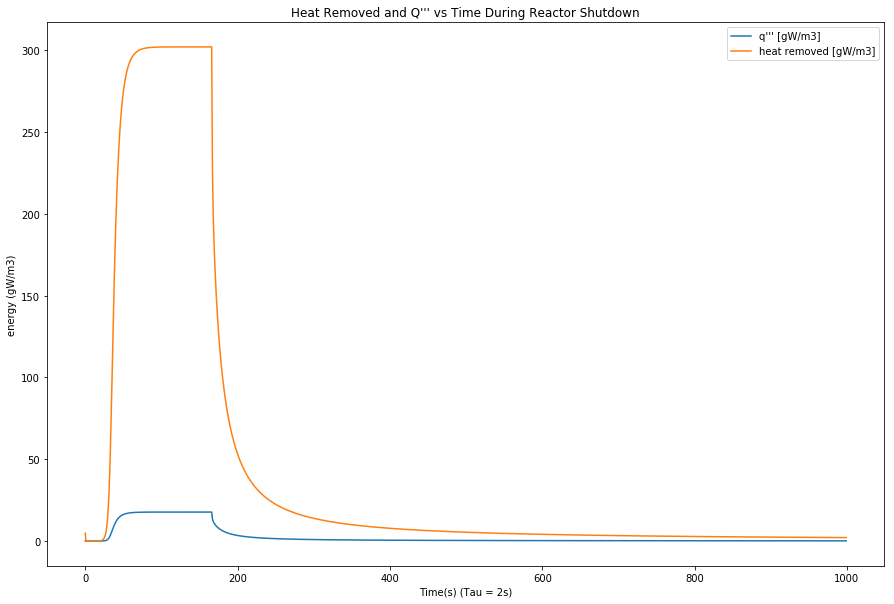

In [11]:
heat_data = reactor.quantities1(u_vec_history, params, params['time_stamps'])
plot = heat_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)
plot.set_xlabel("Time(s) (Tau = 2s)")
plot.set_ylabel("energy (gW/m3)")
plot.set_title("Heat Removed and Q''' vs Time During Reactor Shutdown")

The reactor shuts down as would be expected, with Q''' and heat removed both going to zero after the reactor is shut down.

Text(0.5, 1.0, 'Turbine, Condenser and Net Power vs Time For Reactor Shutdown')

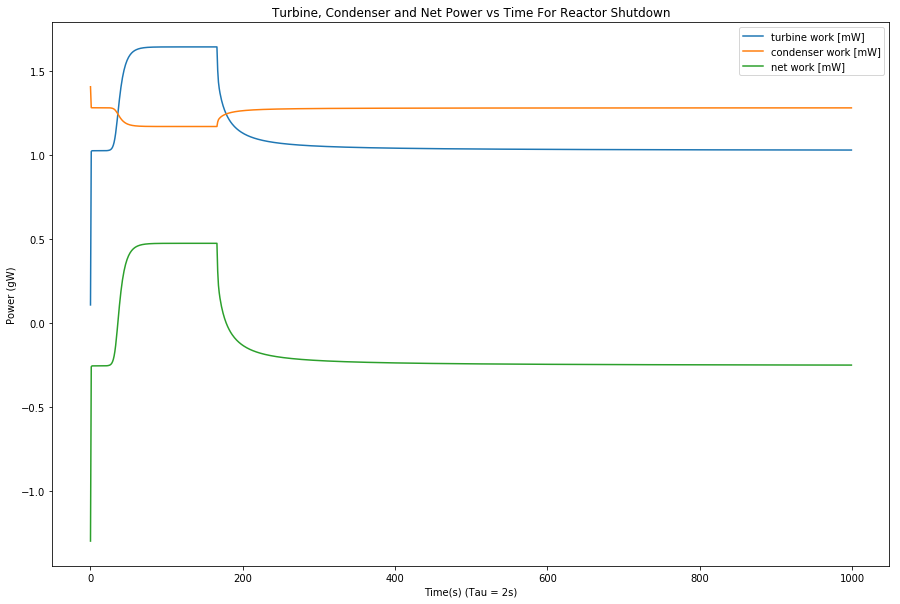

In [12]:
work_data1 = reactor.quantities2(u_vec_history, params, params['time_stamps'])
plot = work_data1.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)
plot.set_xlabel("Time(s) (Tau = 2s)")
plot.set_ylabel("Power (gW)")
plot.set_title("Turbine, Condenser and Net Power vs Time For Reactor Shutdown")

Condenser and turbine work do not decrease to zero, but instead go to new lower steady state values as the ending temperature of the reactor is much higher than the beginning temperature of the reactor, meaning that steam is still flowing to the turbine and liquid must still be pumped to the reactor at relatively high operating pressures.

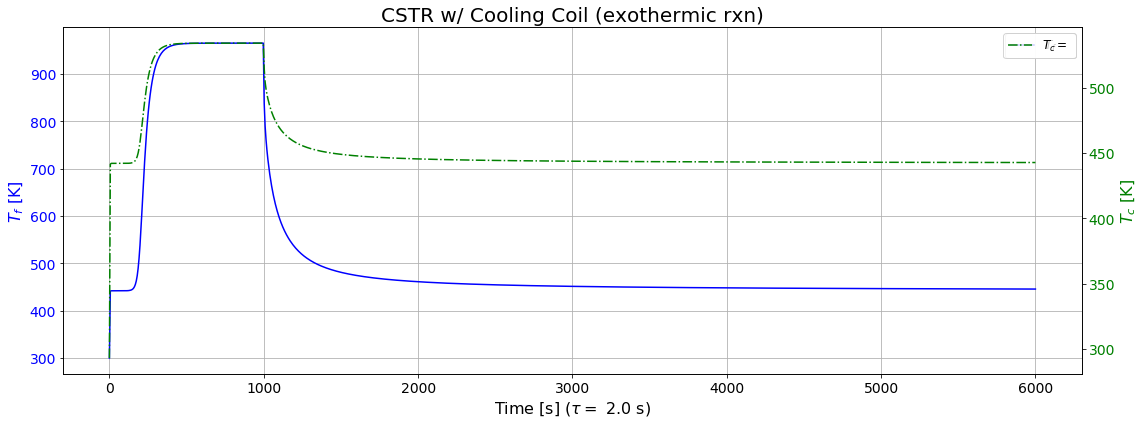

In [13]:
reactor.tmp(u_vec_history, params)

The dual temperature asymtopes seen in reactor startup are also present during the startup in this case. After shut down, the reactor runs to new steady state values for temperature based on the heat removed by the turbine and condenser, at around 440 degrees kelvin for both the coolant and the fuel.

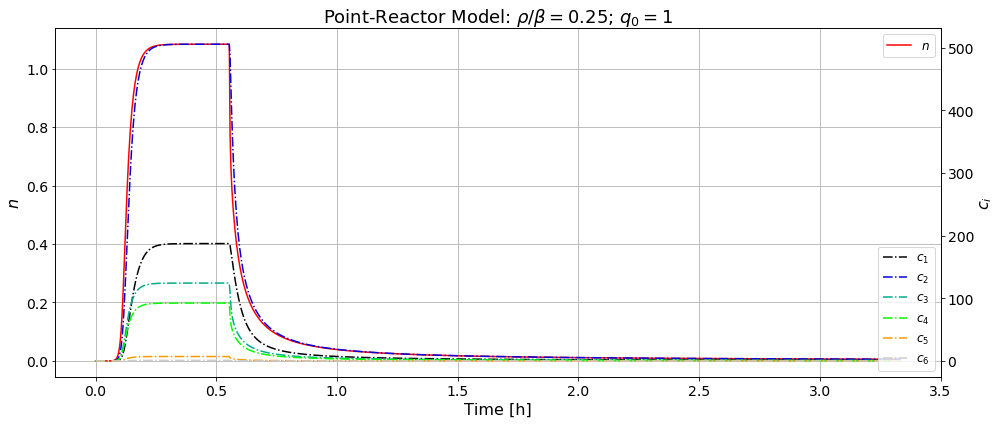

In [14]:
reactor.plot_results(u_vec_history, params, normalize=False)

Neutron and delayed emitter concentrations head to zero after shutdown as is expected.